# About this notebook

This notebook is the first part of a larger collection of notebooks that try to solve the Kaggle Competition - Spaceship Titanic. The goal of this competition is to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

The competition can be found in the following link: https://www.kaggle.com/c/spaceship-titanic/overview

The collection of notebooks is structured as follows:
- Notebook 1: Problem Exploration
- Notebook 2: Data Wrangling + Exploratory Data Analysis
- Notebook 3: Model Selection and Evaluation

In particular, this notebook provides a brief explanation of the "Spaceship Titanic" Kaggle Competition, including its goal, evaluation criteria, and dataset. Additionally, it covers the following matters:

- Introduction to the problem
- Datasets Overview
- Target Analysis
- Numerical Features Analysis
- Categorical Analysis


That being said, let's get started! 🤘


---

# Introduction to the problem

*It is the year 2912, and we have received a transmission from four lightyears away and things aren't looking good.*

*The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.*

*While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!*

*To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.*

So, we could summarize the project as follows:


- Total number of passengers: 13K passengers (14 columns)
- **Goal**: To predict which passengers were transported by the anomaly
- **Target column**: Transported (0 = No, 1 = Yes)
- Evaluation: Accuracy (percentage of passengers correctly predicted)
- Type of problem: Binary Classification

It is important to take into account that although I will approach this problem as a binary classification I will try use different models (logistic regression, random forest, neural networks, etc.) and different feature engineering techniques.

The goal is to learn and practice different techniques and to compare the results obtained with each of them.

<details> 

<summary>  Click here for seeing the dataset </summary>

We are provided with three different datasets:

- **train.csv**: Training dataset with a shape of 8693 rows and 14 columns. This data will be used to train the model.
- **test.csv**: Test dataset with a shape of 4277 rows and 13 columns. This data will be used to test the model.
- **sample_submission.csv**: Sample submission file with a shape of 4277 rows and 2 columns (PassengerId and Transported). This file will be used to submit the predictions to the Kaggle competition.


As we don't have many columns, I will explain the meaning of each of them inside this notebook. All definitions are taken from the Kaggle competition, Data Dictionary section.


| Column       | Description                                                                                                 |
|--------------|-------------------------------------------------------------------------------------------------------------|
| PassengerId  | Unique identifier for each passenger. Likely to be dropped as it does not provide any useful information.  |
| Name         | Name of the passenger. It could be useful to extract the title of the passenger (Mr, Mrs, etc.) and to create a new feature. |
| CryoSleep    | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. |
| Cabin        | Cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| Destination  | The planet the passenger will be debarking to. It can be TRAPPIST-1e, 55 Cancri e, or Other.               |
| Age          | Age of the passenger. It is a continuous variable.                                                         |
| VIP          | Whether the passenger has paid for special VIP service during the voyage.                                  |
| RoomService  | Amount the passenger has billed at the Room Service amenity of Spaceship Titanic.                          |
| FoodCourt    | Amount the passenger has billed at the Food Court amenity of Spaceship Titanic.                            |
| ShoppingMall | Amount the passenger has billed at the Shopping Mall amenity of Spaceship Titanic.                         |
| Spa          | Amount the passenger has billed at the Spa amenity of Spaceship Titanic.                                   |
| VRDeck       | Amount the passenger has billed at the VR Deck amenity of Spaceship Titanic.                                |
| HomePlanet   | The planet the passenger departed from, typically their planet of permanent residence. It can be Earth, Europa, or Other. |

<details>


In [10]:
# Libraries
import os, sys

# Add root folder to path if not already there
root_folder = os.path.dirname(os.getcwd())
if root_folder not in sys.path: sys.path.append(root_folder)

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
new_palette = sns.color_palette("Set2")  # You can replace "Set2" with any other palette name
sns.set_palette(new_palette)
# Own libraries (EDA)
from lib_eda.dataset_analysis import basic_eda_dataset
from lib_eda.target_analysis import basic_eda_target
from lib_eda.features_num import basic_eda_num

path_kaggle_data = r'D:\Kaggle Data'
path_competition = 'spaceship-titanic'
path_data = path_kaggle_data + '/' + path_competition

In [11]:
# Load main datasets
train = pd.read_csv(path_data + '/' + 'train.csv')
test = pd.read_csv(path_data + '/' + 'test.csv')
sample_submission = pd.read_csv(path_data + '/' + 'sample_submission.csv')

submission_ids = test['PassengerId'] # Extract the ids for a future submission

# Get target
TARGET = train['Transported']

## Insights from the overview

Looking at the **main stats** per dataset we can see that:

- Train: Shape of 8693 rows and 14 columns | Test: Shape of 4277 rows and 13 columns
- Target: Transported (0 = No, 1 = Yes). It's completed for all the rows.

We can split the **initial features** into:
- Numerical Features: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (the ones with float64 type). Same columns for both datasets. Additionally, it is worth noting that most of the numerical features, except for the "Age" feature, primarily consist of 0 values. It is important to investigate whether this distribution is accurated or requires further examination.

- Categorical Features: PassengerId, Name, CryoSleep, Cabin, Destination, VIP, HomePlanet (the ones with object type). Same columns for both datasets.

Regarding **missing values and outliers**:
- Some missing values: HomePlanet (2.3%), CryoSleep (2.5%), Cabin (2.3%), Age (2.1%)... we will deal with them later.
- Looking at the main stats, it is expected to see some outliers in the features, we will deal with them later as well.

In [12]:
# basic_eda_dataset(train, 'train') # Uncomment in order to see the main stats
# basic_eda_dataset(test, 'test')

# Target Analysis

Just as a reminder, our target for this problem is to predict **which passengers were transported by the anomaly**. In other words, we have to predict the outcome of the "Transported" column (0 = No, 1 = Yes) for the test dataset.

So let's dive into the main characteristics of the target:

**Class Distribution**

It is important to check the distribution of the target to see if there is any class imbalance. A balanced distribution would have roughly an equal number of passengers transported and not transported. Looking at the number of values for each class, we can see that the **target is balanced**.

If there is a class imbalance, with one class dominating the other, we would have to use some techniques to deal with it (oversampling, undersampling, etc.) as this might lead to a biased model.

In such cases, evaluation metrics such as accuracy are not the best option as they might be misleading. Other metrics like precision, recall, or F1-score would be more appropriate. **In this case, we can use accuracy as the target is balanced.**

In summary, understanding the target variable and its distribution is crucial for selecting appropriate modeling techniques and assessing model performance accurately.

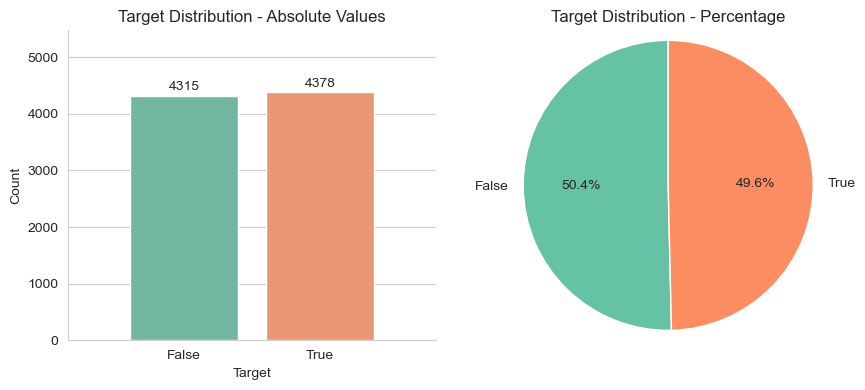

In [13]:
basic_eda_target(TARGET)

# EDA - Numerical features

## Feature - Age
In this section we will perform some basic EDA with the goal of understanding the distribution of each numerical feature and to check for outliers. In order to do that, I will isolate the analysis of *Age* feature from the rest as the other features most of their values are 0.

Regarding the feature *Age*:
- With a mean of 28.8 years old and a median of 27 years old, we can see that the **distribution is right-skewed**. This means that the mean is greater than the median.
- There are **some potential outliers on the right side** of the distribution. However, we will not remove them as they are not extreme outliers and they could be useful for the model.
- However, **the range of values is inside the expected range** (0-100 years old) and there are no negative values.
- Looking the standard deviation of 14.4 years old and the median of 27 years old, we can see that the **data is quite spread out**. This is confirmed by the interquartile range (IQR) of 19 years old.
- We can also see that there are some outliers in the feature *Age*. 

Note: 
*The IQR, also called the midspread, is a measure of statistical dispersion and is calculated as the difference between the upper quartile (Q3) and the lower quartile (Q1). The IQR is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR.*

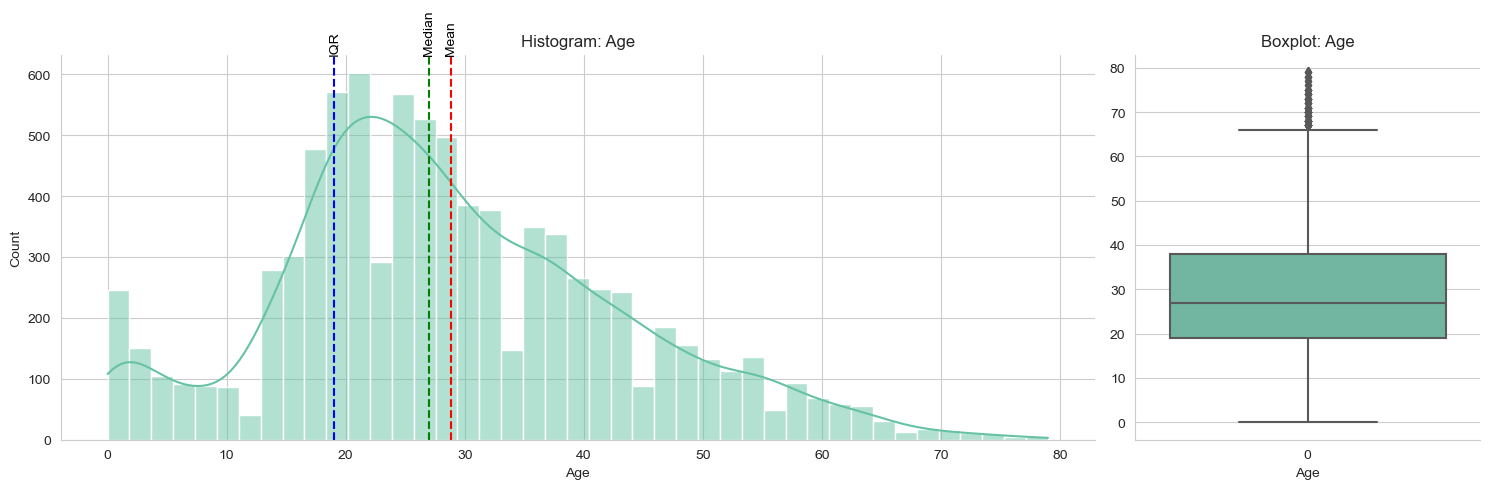

Mean: 28.82793046746535
Median: 27.0
Standard Deviation: 14.489021423908726
Minimum: 0.0
Maximum: 79.0
Range: 79.0
Interquartile Range: 19.0
-----------------------------------
Skewness: 0.42 (right)
Kurtosis: 0.10 (heavy-tailed)


In [14]:
basic_eda_num(train, 'Age', vlines_stats=True)

**EDA - Age and Target relationship**

If we go deeper into the distribution of the feature *Age*, adding the **target** variable to the plots, we can see that we can group passengers by age as it seems that there are some age ranges where the odds of being transported by the anomaly are higher.
- For example, passengers between 0 and 10 years old have a higher probability of being transported by the anomaly.
- On the other hand, passengers between 20 and 40 years old have a lower probability of being transported by the anomaly.

It would be interesting to create a new feature with the age ranges and to check if it improves the model performance. In fact, we could try grouping by different age ranges and to check which one performs better.

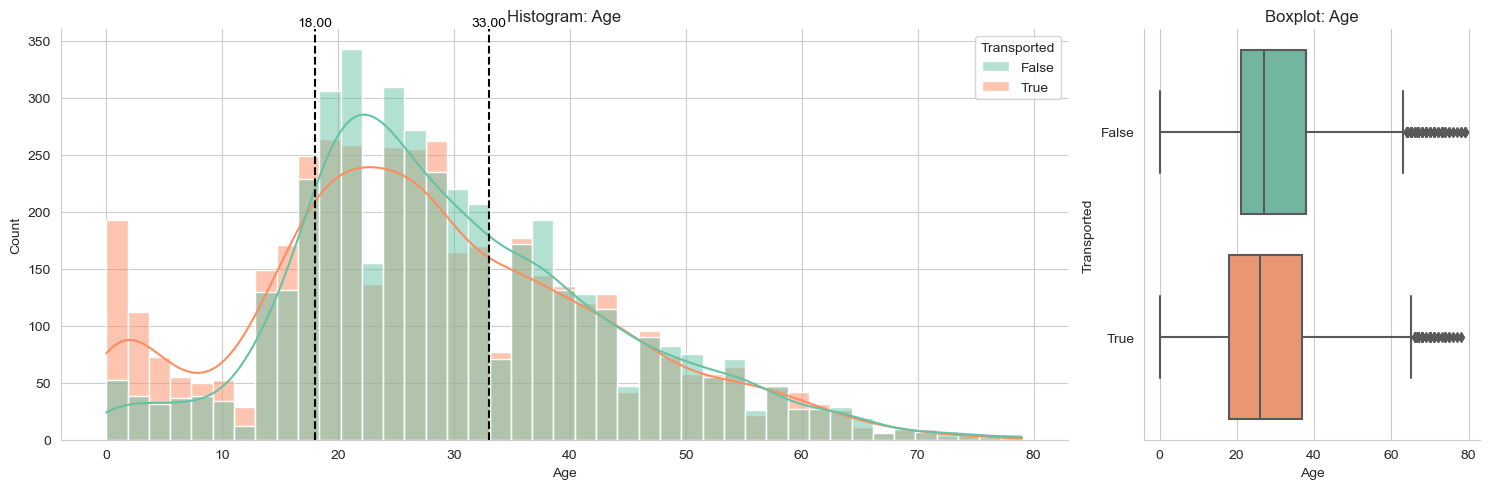

Mean: 28.82793046746535
Median: 27.0
Standard Deviation: 14.489021423908726
Minimum: 0.0
Maximum: 79.0
Range: 79.0
Interquartile Range: 19.0
-----------------------------------
Skewness: 0.42 (right)
Kurtosis: 0.10 (heavy-tailed)


In [15]:
# Create a variable for saving vertical lines to plot in the chart
vlines = [18, 33]
basic_eda_num(train, 'Age', 'Transported', vlines_stats=False, vlines_manual=vlines)

**Actionable Steps from this Analysis**

**1. Handle Missing and Outliers Values**: Check for any missing age values in the dataset and consider appropriate strategies for imputation, such as using the mean or median age or using a predictive model to fill in missing values. Regarding outliers,  they should be retained in the dataset as they could provide valuable information to the model, ensuring that those outliers are not adversely impacting model's performance


**2. Feature Engineering - Age Ranges**: Create a new feature that categorizes passengers into different age ranges based on the insights gained from the distribution analysis: Group child (0-12) | Group teenager (12-17) | Group young adult (18-25) | Group adult (26-30) | Group middle-aged (31-50) | Group senior (50+)- 


*Optional course of action*

**3. Explore Age and Survival Relationship**: Analyze the relationship between age and survival rates to identify patterns or trends. Consider using visualizations like histograms or box plots to understand how age influences the chances of survival.

**4. Age and Other Features Interaction:** Investigate possible interactions between age and other features. This can help identify groups of passengers that may have distinct survival patterns based on their age and other characteristics.

## Features - Billing

It is clear, looking at the distributions, that most passengers didn't expend any money in the trip. In fact, looking at the description of these features, it seems like luxury services for the journey.

In summary:
- Just a few passengers are using the luxury services such as VRDeck, Spa, etc.
- The likelyhood of a passenger being transported increased if they expend less money in the trip.

**Actionable Steps from this Analysis**

1. New feature: hasSpentMoney (boolean)
2. New feature: totalSpentMoney (float)
3. Take the log transformation of the totalSpentMoney feature for a better distribution.

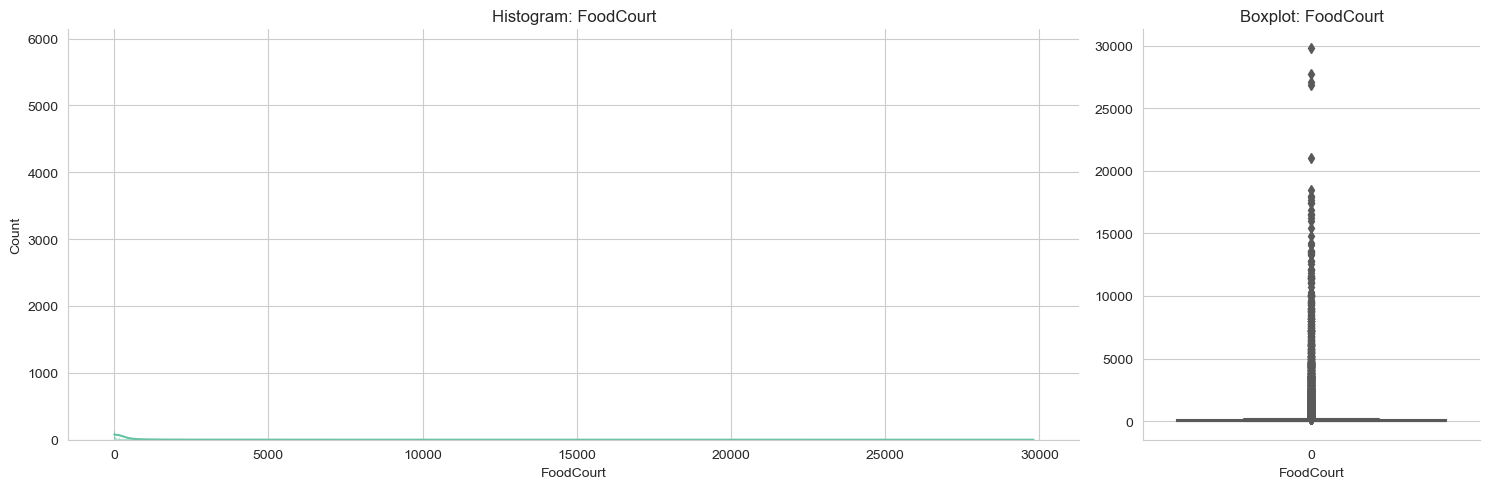

Mean: 458.07720329024676
Median: 0.0
Standard Deviation: 1611.4892403551144
Minimum: 0.0
Maximum: 29813.0
Range: 29813.0
Interquartile Range: 76.0
-----------------------------------
Skewness: 7.10 (right)
Kurtosis: 73.31 (heavy-tailed)


In [16]:
# Create tabs widget for each each numerical feature that is not the Age
cols_num = ['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
basic_eda_num(train, 'FoodCourt')

# EDA - Categorical features

The current categorical features include the following: `HomePlanet`, `CryoSleep`, `Destination`, and `VIP`. Let's delve into their distributions and examine the insights they offer.

Upon scrutinizing these distributions, we can discern valuable information from the categorical features:

1. **VIP** does not appear to be a useful feature since it **exhibits nearly equal distribution between the two classes**. Consequently, it is unlikely to assist the model in distinguishing between them effectively.

2. On the other hand, **CryoSleep proves to be a promising feature**. It demonstrates an non-equal distribution between the two classes, implying its potential to aid the model in differentiation.


**Actionable Steps from this Analysis**

1. It is advisable to exclude the `VIP` feature from our model, as it does not contribute significantly to distinguishing between the classes.

2. We should consider employing one-hot encoding for the `HomePlanet`, `CryoSleep`, and `Destination` features. This encoding method can enhance our model's ability to utilize these features effectively.

Text(0.5, 1.0, 'VIP distribution')

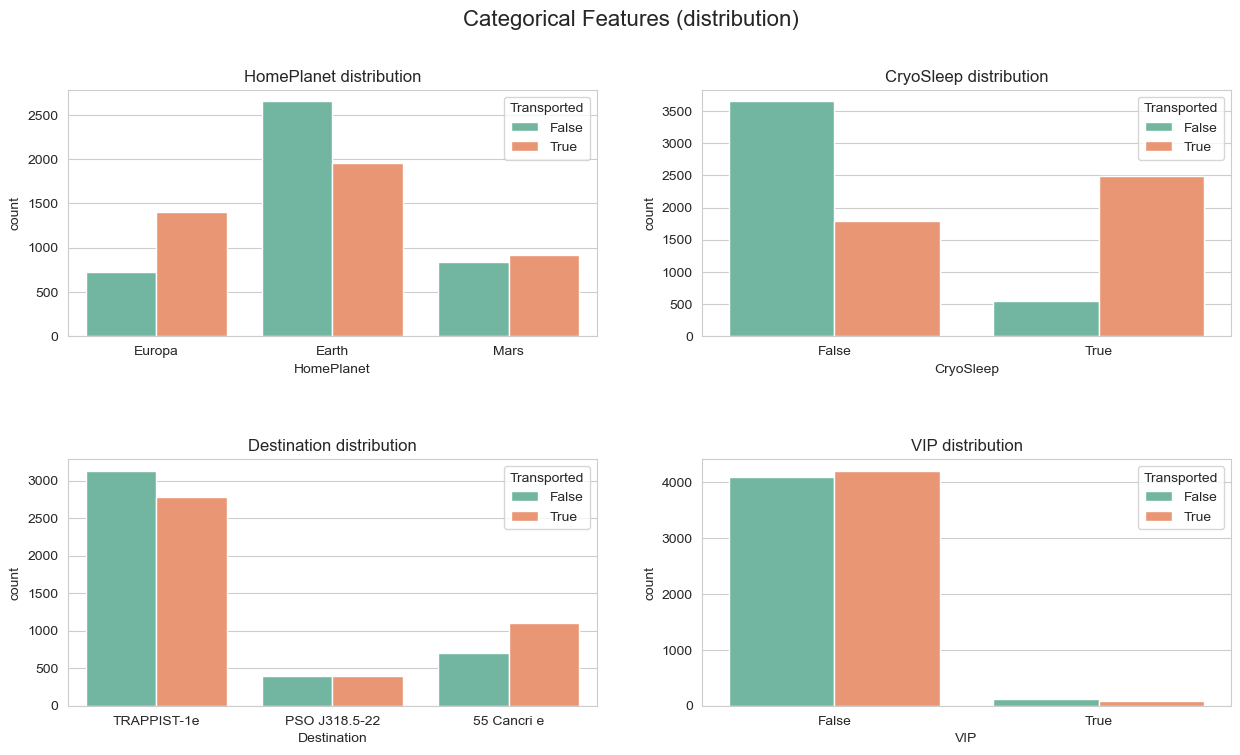

In [17]:
cols_categorical = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Categorical Features (distribution)', fontsize=16)

sns.countplot(x='HomePlanet', data=train, hue='Transported', ax=axes[0, 0]) # plot 1
axes[0, 0].set_title('HomePlanet distribution')

sns.countplot(x='CryoSleep', data=train, hue='Transported', ax=axes[0, 1]) # plot 2
axes[0, 1].set_title('CryoSleep distribution')
# Add some space between the plots
plt.subplots_adjust(hspace=0.5)
sns.countplot(x='Destination', data=train, hue='Transported', ax=axes[1, 0]) # plot 3
axes[1, 0].set_title('Destination distribution')

sns.countplot(x='VIP', data=train, hue='Transported', ax=axes[1, 1]) # plot 4
axes[1, 1].set_title('VIP distribution')